#**과제: 차원 축소 실습 및 시각화**



###**차원축소 실습**
1. 코드의 과정을 이해하고 주석 및 빈칸을 채워주세요
2. 최적의 주성분 또는 latent space를 정해서 차원축소를 진행하고 그 이유를 서술해주세요


PCA

원하는 분산 설명 비율을 정하고 시각화를 진행해 필요한 주성분 개수를 정해봅시다!

In [1]:
digits = load_digits()
X = digits.data
y = digits.target

import numpy as np

NameError: name 'load_digits' is not defined

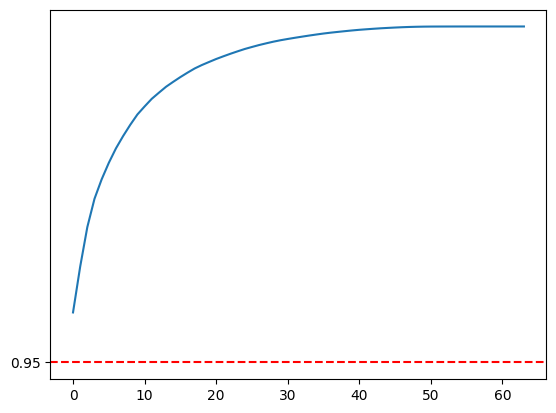

In [8]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

##1. 주석을 작성해주세요
#데이터 평균을 각 특성별로 제거하여 중심화 시킴
X_mean=X-np.mean(X,axis=0)

##2. SVD를 사용하여 주성분석하기
U,S,Vt=np.linalg.svd(X_mean)

##3. 주성분 분석을 행렬로 저
principle_components=Vt.T

##4. 분산설명비율 계산
explained_variance = (S ** 2) / (X.shape[0] - 1) # 각 주성분의 분산 계산
explained_variance_ratio = explained_variance / np.sum(explained_variance) #전체 분산에 대한 비율
cumsum = np.cumsum(explained_variance_ratio) # 누적 분산 설명 비율 계산

plt.plot(cumsum)

##5.원하는 분산 설명 비율을 y의 값으로 작성해주세요
plt.axhline(y="0.95", color="r", linestyle="--", label="Threshold")


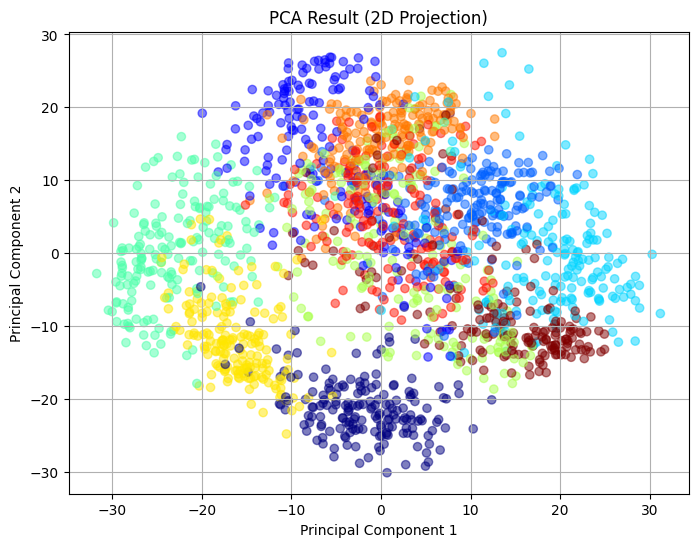

In [9]:
##6. 분산 설명 비율을 만족하는 주성분 개수까지 eigen vector를 잘라봅시다
principle_components= Vt[:np.where(cumsum >= 0.95)[0][0] + 1].T

##7. 원본 데이터를 선택한 주성분 공간으로 변환하여 차원 축소 수행
X_pca=np.dot(X_mean,principle_components)

##8. 2차원 시각화이지만, 원하신다면 변형하셔도 됩니다.
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1],  c=y, cmap="jet", alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Result (2D Projection)")
plt.grid(True)
plt.show()

문제. PCA에서는 어떤 주성분을 사용하셨나요? 그리고 그 이유는 뭔가요?

답. 분산 설명 비율이 95% 이상이 되는 주성분을 사용하였다. 즉 cumsum이 0.95 이상이 되는 최소개수의 주성분을 선택한 것이다. 그 이유는 PCA는 데이터의 분산을 최대한 유지하는 방향으로 변환하는데, 분산이 큰 축 즉 주성분이 데이터의 주요 정보를 포함하고 있기 때문이다. 따라서 정보 손실을 최소화하면서도 차원을 줄여 연산효율을 높이고, 노이즈를 줄이며, 과적합을 방지하기 위해서 누적 분산 설명 비율이 95% 이상이 되는 최소개수의 주성분을 선택하였다.

LDA

선택된 최적의 n_components: 8


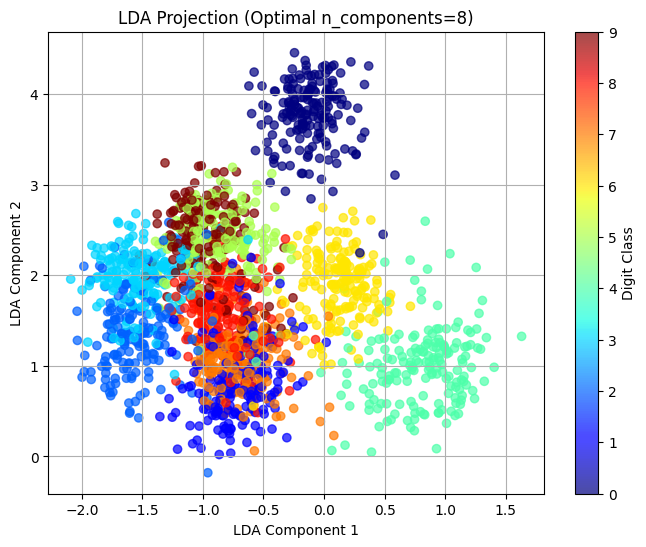

In [11]:
##1. zero-normalization 으로 데이터를 정규화함
X_scaled = X-np.mean(X)

##2. 각 클래스별 평균 벡터 계산
#mean vectors: 각 클래스별 평균 벡터를 저장하는 리스트
class_labels = np.unique(y)
mean_vectors = [np.mean(X_scaled[y == label], axis=0) for label in class_labels]
mean_vectors = np.array(mean_vectors)

##3. 클래스 내 분산 행렬 S_W 계산
# S_W: 모든 클래스에 대한 클래스 내 분산 행렬을 합산하여 생성
#class_scatter: 각 클래스 내부의 데이터 분산을 계산
S_W = np.zeros((X.shape[1], X.shape[1]))
for label, mean_vec in zip(class_labels, mean_vectors):
    class_scatter = np.zeros((X.shape[1], X.shape[1]))
    for row in X_scaled[y == label]:
        row = row.reshape(-1, 1)
        mean_vec = mean_vec.reshape(-1, 1)
        class_scatter += (row - mean_vec) @ (row - mean_vec).T # (X - μ) (X - μ)^T
    S_W += class_scatter # 모든 클래스의 클래스 내 분산 행렬을 더함

##4. 클래스 간 분산행렬( between-class scatter matrix) S_B 계산
overall_mean = np.mean(X_scaled, axis=0).reshape(-1, 1) #전체 데이터의 평균 벡터
S_B = np.zeros((X.shape[1], X.shape[1])) #클래스 간 평균 차이를 고려하여 분산행렬을 생성
for label, mean_vec in zip(class_labels, mean_vectors):
    mean_vec = mean_vec.reshape(-1, 1)
    n = X_scaled[y == label].shape[0] # 클래스 내에 샘플 개수
    S_B += n * (mean_vec - overall_mean) @ (mean_vec - overall_mean).T # (μ - μ_overall)(μ - μ_overall)^T

##5. 일반화된 고유값 문제해결을 위한 행렬 변환
#S_W를 정규화하여 M 행렬 생성_ LDA의 핵심
U, S, Vt = np.linalg.svd(S_W) #SVD를 이용한 역행렬 계산
S_inv = np.diag(1 / S) #대각행렬의 역행렬 계산
S_W_inv = Vt.T @ S_inv @ U.T #S_w의 역행렬 근사값 계산

M = S_W_inv @ S_B # S_W의 역행렬과 S_B를 곱하여 최적 변환행렬 M 생성
eigenvalues, eigenvectors = np.linalg.eig(M) #고유값 분해 수행

#고유값을 내림차순 정렬
idx = np.argsort(-eigenvalues.real)
eigenvalues = eigenvalues[idx].real
eigenvectors = eigenvectors[:, idx].real

##6. 분산 설명 비율 계산
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(explained_variance_ratio)

##5.원하는 분산 설명 비율을 cumulative_variance의 조건식에 작성해주세요
n_components = np.argmax(cumulative_variance >= 0.95) + 1
#뒤에 1을 붙이는 이유는 python이 0-based indexing이기 때문에 1부터 시작하는 개수로 변환해주는 작업이 필요
print(f"선택된 최적의 n_components: {n_components}")

##6.분산 설명 비율을 만족하는 n_components까지 eigenvector를 자를 수 있도록 빈칸에 알맞게 작성해주세요
W_lda = eigenvectors[:, :n_components]
X_lda = X_scaled @ W_lda #데이터 투영

# 2D 시각화 (LDA 결과를 2D 공간에 투영)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap="jet", alpha=0.7)
plt.colorbar(scatter, label="Digit Class")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.title(f"LDA Projection (Optimal n_components={n_components})")
plt.grid()
plt.show()


Autoencoder

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset


##1. 데이터 정균화 zero normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

#tensordataset과 dataloader를 사용하여 데이터 배치 처리
dataset = TensorDataset(X_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

##2. Autoencoder 클래스 정의
# 인코더: 입혁 데이터를 저차원 즉 latent_dim으로 압축
# 디코더: 저차원 데이터에서 원래 데이터 복원
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2): #저차원을 2차원으로
        super(Autoencoder, self).__init__()
#압축하는 부분
        self.encoder = nn.Sequential(
            nn.Linear(64, 32), #입력차원 64->32
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim) #16 ->2
        )
#복원하는 부분
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Sigmoid() #출력을 [0,1] 범위로 제한
        )

    def forward(self, x):
        z = self.encoder(x) #입력 데이터를 저차원 표현으로 변환
        x_recon = self.decoder(z) #복원
        return x_recon, z

##3. 모델 초기화 및 학습 설절
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(latent_dim=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

문제. LDA에서는 어떤 주성분을 사용하셨나요? 그리고 그 이유는 뭔가요?

답. 클래스 간 분산을 최대로 증가시키는 방향 즉 고유벡터(eigenvector)를 주성분으로 사용하였습니다. 왜냐하면 LDA의 목적은 클래스간 분류이기 때문에 PCA와 달리 데이터 전체의 분산이 아닌 클래스 간 분리를 최대화시키는 것을 선택한 것입니다.

Autoencoder-분류기를 통한 성능 평가

Latent Dim: 2, Accuracy: 0.6333
Latent Dim: 4, Accuracy: 0.8861
Latent Dim: 8, Accuracy: 0.6589
Latent Dim: 10, Accuracy: 0.8794


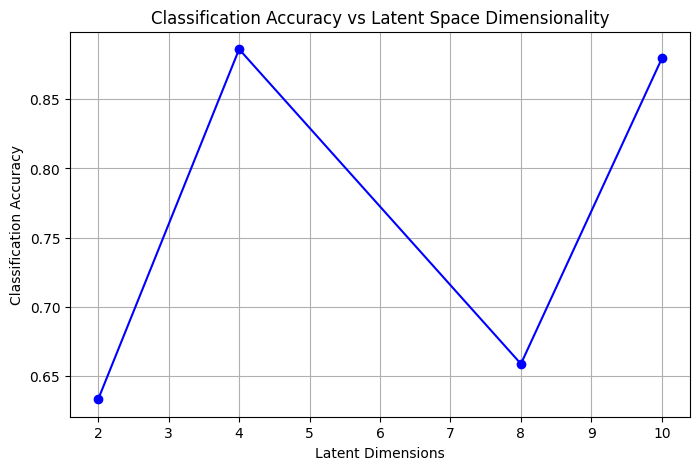

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

##원하는 latent_dims로 실험해보세요!!
latent_dims = [2,4,8,10]  ##eg. latent_dims[3,4]
accuracies = []

##learning rate 조절하셔도 됩니다
for dim in latent_dims:
    model = Autoencoder(latent_dim=dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    accuracy=0

##epoch 조절하셔도 됩니다
    for i in range(0,10):
      num_epochs = 30
      for epoch in range(num_epochs):
          for X_batch, _ in data_loader:
              X_batch = X_batch.to(device)
              recon, _ = model(X_batch)
              loss = criterion(recon, X_batch)

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()


      X_encoded = []
      y_labels = []
      with torch.no_grad():
          for X_batch, y_batch in data_loader:
              X_batch = X_batch.to(device)
              _, z = model(X_batch)
              X_encoded.append(z.cpu().numpy())
              y_labels.append(y_batch.numpy())

      X_encoded = np.vstack(X_encoded)
      y_labels = np.hstack(y_labels)

      ##분류기로 성능 평가를 진행해보겠습니다
      X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_labels, test_size=0.2, random_state=42)
      clf = RandomForestClassifier(n_estimators=100, random_state=42)
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      accuracy += accuracy_score(y_test, y_pred)

    accuracies.append(accuracy/10)

    print(f"Latent Dim: {dim}, Accuracy: {accuracy/10:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(latent_dims, accuracies, marker="o", linestyle="-", color="b")
plt.xlabel("Latent Dimensions")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy vs Latent Space Dimensionality")
plt.grid()
plt.show()

Autoencoder 결과 시각화

원하는 latent space를 지정해서 시각화를 진행해봅시다

Epoch [1/20], Loss: 29.3623
Epoch [2/20], Loss: 27.5559
Epoch [3/20], Loss: 27.5916
Epoch [4/20], Loss: 27.5192
Epoch [5/20], Loss: 26.8168
Epoch [6/20], Loss: 26.6111
Epoch [7/20], Loss: 26.4859
Epoch [8/20], Loss: 26.2161
Epoch [9/20], Loss: 25.7963
Epoch [10/20], Loss: 25.5217
Epoch [11/20], Loss: 25.6122
Epoch [12/20], Loss: 25.3190
Epoch [13/20], Loss: 25.1117
Epoch [14/20], Loss: 24.9465
Epoch [15/20], Loss: 24.9489
Epoch [16/20], Loss: 25.1610
Epoch [17/20], Loss: 24.8551
Epoch [18/20], Loss: 24.8497
Epoch [19/20], Loss: 24.8248
Epoch [20/20], Loss: 24.6854


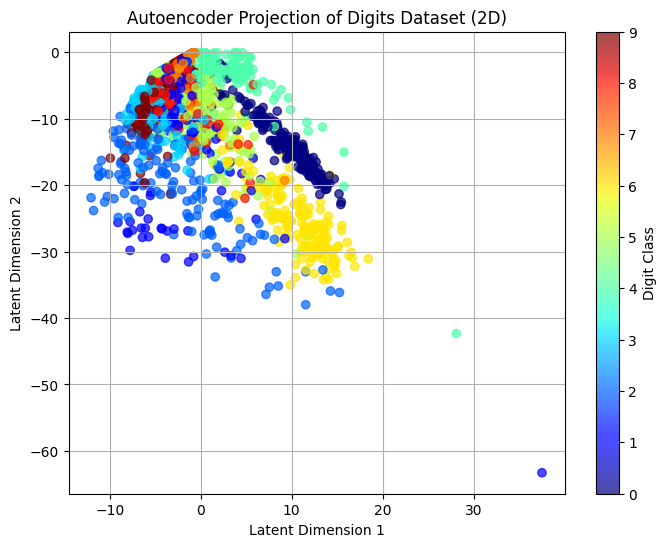

In [25]:
model = Autoencoder(latent_dim=4).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, _ in data_loader:
        X_batch = X_batch.to(device)
        recon, _ = model(X_batch)
        loss = criterion(recon, X_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

X_encoded = []
y_labels = []

with torch.no_grad():
    for X_batch, y_batch in data_loader:
        X_batch = X_batch.to(device)
        _, z = model(X_batch)
        X_encoded.append(z.cpu().numpy())
        y_labels.append(y_batch.numpy())

X_encoded = np.vstack(X_encoded)
y_labels = np.hstack(y_labels)


plt.figure(figsize=(8, 6))
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=y_labels, cmap="jet", alpha=0.7)
plt.colorbar(label="Digit Class")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Autoencoder Projection of Digits Dataset (2D)")
plt.grid()
plt.show()

문제. Autoencoder에서는 어떤 latent space를 사용하셨나요? 그리고 그 이유는 뭔가요?

답. latent space 가 4일 때를 사용하였습니다. 그 이유는 분류기를 통해 성능 평가를 하였을때 4일때가 accuracy가 가장 높게 나왔기 때문입니다.

###**T-SNE를 이용한 시각화**
PCA와 t-SNE의 차원 축소 결과를 시각화하고 비교해보세요. 답 작성란은 아래에 있습니다:)

In [26]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd


data_digit= datasets.load_digits()

df_digit = pd.DataFrame(data = data_digit['data'], columns=data_digit['feature_names'])
label_digit = data_digit['target']

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne = TSNE(n_components=2)

df_digit_tsne=pd.DataFrame(data=tsne.fit_transform(df_digit),columns=["col1","col2"])
df_digit_tsne["label"]=label_digit

scaler=StandardScaler()
df_digit_scaled=pd.DataFrame(data=scaler.fit_transform(df_digit))

pca=PCA(n_components=2)
df_digit_pca=pd.DataFrame(data=pca.fit_transform(df_digit_scaled),columns=["col1","col2"])


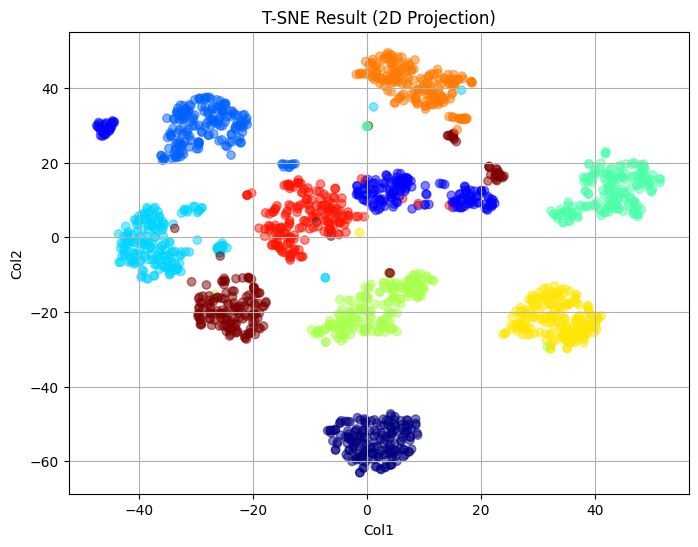

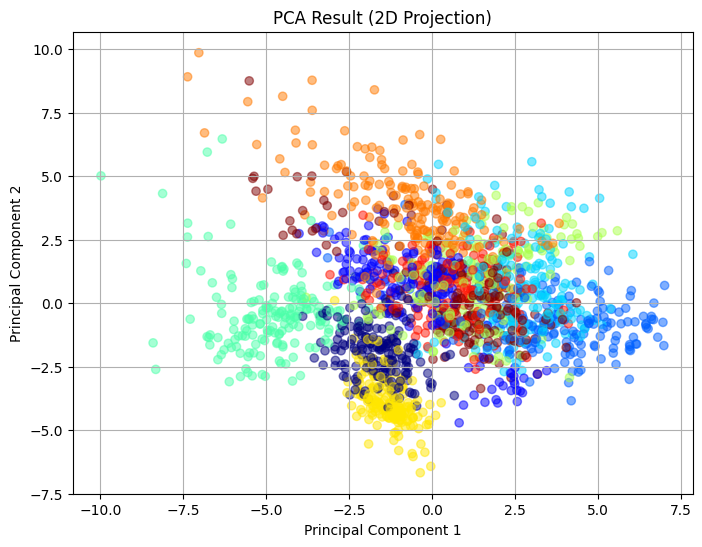

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(df_digit_tsne['col1'], df_digit_tsne['col2'],  c=label_digit, cmap="jet", alpha=0.5)
plt.xlabel("Col1")
plt.ylabel("Col2")
plt.title("T-SNE Result (2D Projection)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df_digit_pca['col1'], df_digit_pca['col2'],  c=label_digit, cmap="jet", alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Result (2D Projection)")
plt.grid(True)
plt.show()

문제. 어떤 차원축소 기법이 더 좋은 시각화 결과를 냈는지, 이 이유가 무엇인지 서술하세요

답:T- SNE를 사용하였을때 클래스 간 분리가 PCA보다 월등히 잘 됨을 그래프를 통해 확인할 수 있습니다. 그 이유는 먼저 T-SNE는 비선형 자원 축소 방법으로 가까운 데이터끼리는 더 가까이, 멀리 위치한 데이터는 멀리 배치하여 시각화하기 때문에 비선형적인 구조나 복잡한 관계를 비굑적 잘 드러낼 수 있기 때문입니다. 이에 반한 PCA는 선형 차원죽소 방법이어서 복잡한 데이터에 대해서는 성능이 떨어집니다. 두번째로 PCA는 전체 데이터의 분산을 최대화하는 방향으로 진행되기 때문에 국소적 구조는 잘 보존이 되지 않습니다. 하지만 T-SNE는 데이터 포인트 간의 상대적인 거리와 밀집도를 고려하여, 국소적인 군집을 잘 유지합니다. 따라서 클러스터링된 구조나 유사한 특성을 가진 그룹을 시각적으로 더 명확하게 구별할 수 있습니다.